# Progetto di Intelligenza Artificiale 2 - A.A. 2025/2026
## Classificazione di Skillshot in Rocket League tramite Serie Temporali

**Gruppo di Lavoro:**
*   **Brando Cappucci** (Matricola: 2139484)
*   **Matteo Maria Martino Remondini** (Matricola: 2136808)
*   **Lorenzo Stranieri** (Matricola: 2153723)

---

### 1. Introduzione e Setup

In questo progetto affrontiamo un problema di classificazione supervisionata su dati di telemetria videoludica. L'obiettivo è distinguere diverse manovre acrobatiche (*skillshot*) eseguite nel gioco *Rocket League*.

A differenza di approcci che dipendono da repository personali, in questo lavoro acquisiremo i dati direttamente dalla fonte ufficiale: l'**UCI Machine Learning Repository**. Questo garantisce la riproducibilità scientifica dell'esperimento.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
import zipfile

# Configurazione dello stile per i grafici
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.1)

# URL Diretto alla fonte ufficiale UCI (Endpoint statico)
DATASET_URL = "https://archive.ics.uci.edu/static/public/858/rocket+league+skillshots.zip"
ZIP_NAME = "rocket_league_skillshots.zip"
DATA_FILE_NAME = "rocket_league_skillshots.data"

def download_and_extract_data(url, zip_name, target_file):
    """
    Scarica il dataset direttamente dal repository UCI ed estrae il file necessario.
    """
    # 1. Scaricamento del file ZIP
    if not os.path.exists(target_file):
        print(f"Dataset non trovato. Avvio scaricamento da: {url}")
        try:
            urllib.request.urlretrieve(url, zip_name)
            print("Download completato. Estrazione in corso...")

            # 2. Estrazione
            with zipfile.ZipFile(zip_name, 'r') as zip_ref:
                zip_ref.extractall()
            print(f"File estratto con successo: {target_file}")

            # Pulizia: rimuoviamo lo zip per mantenere l'ambiente pulito
            os.remove(zip_name)

        except Exception as e:
            print(f"Errore durante il download o l'estrazione: {e}")
            print("Verificare la connessione o l'URL del repository.")
    else:
        print(f"Il file '{target_file}' è già presente nell'ambiente di lavoro.")

# Esecuzione del download
download_and_extract_data(DATASET_URL, ZIP_NAME, DATA_FILE_NAME)

# Verifica rapida della presenza del file
if os.path.exists(DATA_FILE_NAME):
    print(f"\nVerifica: Il file '{DATA_FILE_NAME}' è pronto per l'analisi.")
else:
    print(f"\nAttenzione: Il file '{DATA_FILE_NAME}' non è stato trovato.")

Dataset non trovato. Avvio scaricamento da: https://archive.ics.uci.edu/static/public/858/rocket+league+skillshots.zip
Download completato. Estrazione in corso...
File estratto con successo: rocket_league_skillshots.data

Verifica: Il file 'rocket_league_skillshots.data' è pronto per l'analisi.


### 2. Parsing e Strutturazione del Dataset

Il dataset grezzo presenta una struttura non tabulare complessa: righe contenenti solo l'etichetta della classe si alternano a blocchi di righe contenenti i dati dei frame (serie temporali).

Invece di iterare sul file riga per riga con un ciclo Python (approccio lento e inefficiente), adottiamo un **approccio vettoriale basato su Pandas**.
1.  Carichiamo l'intero file come un'unica colonna di testo.
2.  Sfruttiamo le operazioni vettoriali sulle stringhe (`.str.split`) per separare i dati.
3.  Identifichiamo le righe di "intestazione manovra" (che contengono solo 1 valore) rispetto a quelle dei dati.
4.  Usiamo la somma cumulativa (`cumsum`) e il riempimento in avanti (`ffill`) per propagare l'ID della sequenza e la classe a tutti i frame corrispondenti senza mai usare un ciclo `for`.

Questo metodo è computazionalmente più efficiente e sfrutta le ottimizzazioni interne di Pandas/NumPy.

In [2]:
def load_and_parse_vectorized(filename):
    """
    Carica il file .data utilizzando tecniche vettoriali di Pandas.
    Evita cicli espliciti per massimizzare le performance.
    """
    print("Avvio del parsing vettoriale...")

    # 1. Leggiamo la prima riga per ottenere i nomi delle feature (Header)
    with open(filename, 'r') as f:
        header = f.readline().strip().split()

    # 2. Carichiamo tutto il resto del file come un DataFrame grezzo di una sola colonna
    # Usiamo un separatore improbabile ('|') per forzare la lettura intera della riga
    raw_df = pd.read_csv(filename, skiprows=1, header=None, names=['raw_string'], sep='|')

    # 3. Splittiamo la stringa in colonne separate
    # expand=True crea un DataFrame con una colonna per ogni valore
    split_data = raw_df['raw_string'].str.strip().str.split(expand=True)

    # 4. Identificazione delle righe "Etichetta" vs "Dati"
    # Le righe che contengono l'etichetta della classe hanno solo 1 valore.
    # Quindi la seconda colonna (indice 1) sarà None/NaN per queste righe.
    mask_is_label = split_data[1].isna()

    # 5. Generazione Sequence_ID
    # Ogni volta che incontriamo una riga "etichetta" (True), incrementiamo il contatore.
    # La cumsum() fa proprio questo vettorialmente.
    raw_df['Sequence_ID'] = mask_is_label.cumsum()

    # 6. Propagazione della Class_Label
    # Estraiamo il valore dalla prima colonna solo dove è una riga etichetta
    raw_df['temp_label'] = pd.to_numeric(split_data[0], errors='coerce')
    # Mettiamo a NaN i valori che non sono etichette per poter fare il forward fill
    raw_df.loc[~mask_is_label, 'temp_label'] = np.nan
    # Ffill() propaga l'ultima etichetta valida verso il basso (sulle righe dei dati)
    raw_df['Class_Label'] = raw_df['temp_label'].ffill()

    # 7. Costruzione del DataFrame Finale
    # Teniamo solo le righe che NON sono etichette (ovvero i frame di dati)
    final_df = split_data[~mask_is_label].copy()

    # Assegnamo i nomi corretti alle colonne
    # Nota: split_data ha creato colonne 0, 1, 2... che corrispondono all'header
    final_df.columns = header

    # Aggiungiamo le meta-informazioni calcolate
    final_df['Sequence_ID'] = raw_df.loc[~mask_is_label, 'Sequence_ID']
    final_df['Class_Label'] = raw_df.loc[~mask_is_label, 'Class_Label']

    # 8. Conversione dei tipi di dato (da stringa a numerico)
    # Riorganizziamo anche le colonne per avere ID e Classe all'inizio
    cols_order = ['Sequence_ID', 'Class_Label'] + header
    final_df = final_df[cols_order].apply(pd.to_numeric)

    # Casting specifico per ID e Classe (interi)
    final_df['Sequence_ID'] = final_df['Sequence_ID'].astype(int)
    final_df['Class_Label'] = final_df['Class_Label'].astype(int)

    return final_df

# Esecuzione
df = load_and_parse_vectorized(DATA_FILE_NAME)

# Verifica Output
print(f"Parsing completato.")
print(f"Dataset Shape: {df.shape}")
print(f"Manovre uniche identificate: {df['Sequence_ID'].nunique()}")
display(df.head())
df.info()

Avvio del parsing vettoriale...
Parsing completato.
Dataset Shape: (6892, 20)
Manovre uniche identificate: 298


,Sequence_ID,Class_Label,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,up,accelerate,slow,goal,left,boost,camera,down,right,slide,jump
1,1,6,1636.798772,0.000000,3498.01,2012.98,299.668270,104267.426232,99035.849337,0,0,0,0,0,0,0,0,1,0,1
2,1,6,3198.029397,0.138893,3494.08,2012.98,229.896780,124248.031988,102233.878734,0,0,0,0,0,1,0,0,1,0,1
3,1,6,0.000000,0.173617,3494.08,2012.98,237.350599,124248.031988,102968.358990,0,0,0,0,0,1,0,0,0,0,0
4,1,6,9914.766242,0.312510,3500.08,2012.98,151.880921,115248.016009,112883.125231,0,0,0,0,0,0,0,0,1,0,0
5,1,6,5907.747166,0.625019,3521.65,2013.00,154.556104,125091.256173,118790.872398,0,0,0,0,0,0,0,0,1,0,1


<class 'pandas.core.frame.DataFrame'>
Index: 6892 entries, 1 to 7189
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sequence_ID       6892 non-null   int64  
 1   Class_Label       6892 non-null   int64  
 2   BallAcceleration  6892 non-null   float64
 3   Time              6892 non-null   float64
 4   DistanceWall      6892 non-null   float64
 5   DistanceCeil      6892 non-null   float64
 6   DistanceBall      6892 non-null   float64
 7   PlayerSpeed       6892 non-null   float64
 8   BallSpeed         6892 non-null   float64
 9   up                6892 non-null   int64  
 10  accelerate        6892 non-null   int64  
 11  slow              6892 non-null   int64  
 12  goal              6892 non-null   int64  
 13  left              6892 non-null   int64  
 14  boost             6892 non-null   int64  
 15  camera            6892 non-null   int64  
 16  down              6892 non-null   int64  
 17  

### 3. Analisi Esplorativa dei Dati (EDA)

In questa fase indaghiamo le caratteristiche strutturali del dataset per orientare le scelte di modellazione. Ci focalizziamo su due aspetti critici:
1.  **Distribuzione delle Classi:** Per capire se il dataset è bilanciato o se richiede metriche di valutazione specifiche (come l'F1-score pesato).
2.  **Variabilità Temporale:** Per analizzare la durata delle manovre. Se la durata varia, avremo la conferma matematica che i dati non possono essere passati direttamente a un classificatore standard senza un processo di *feature engineering*.

Per visualizzare questi aspetti, utilizziamo un **Donut Chart** (per le proporzioni relative) e un **Box Plot stratificato** (per analizzare la distribuzione della durata specifica per ogni tipo di manovra).

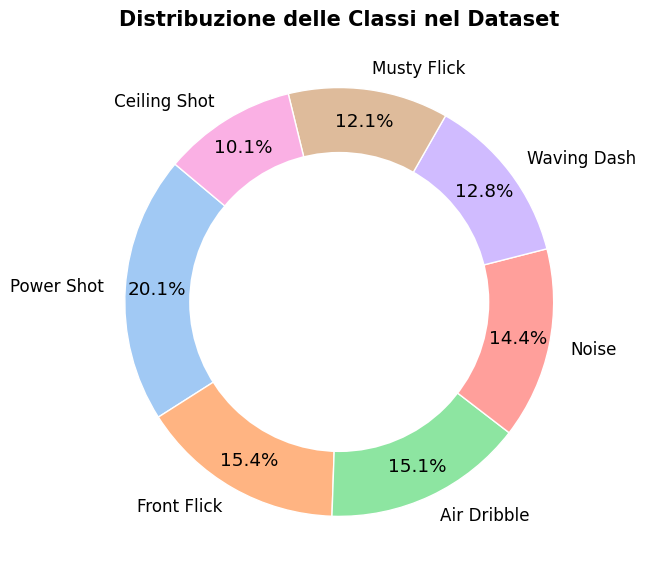

Osservazione: La classe più frequente è 'Power Shot' (60 campioni).
Osservazione: La classe meno frequente è 'Ceiling Shot' (30 campioni).
Conclusione: Il dataset è sbilanciato. L'Accuracy non è una metrica affidabile; useremo l'F1-Score Weighted.



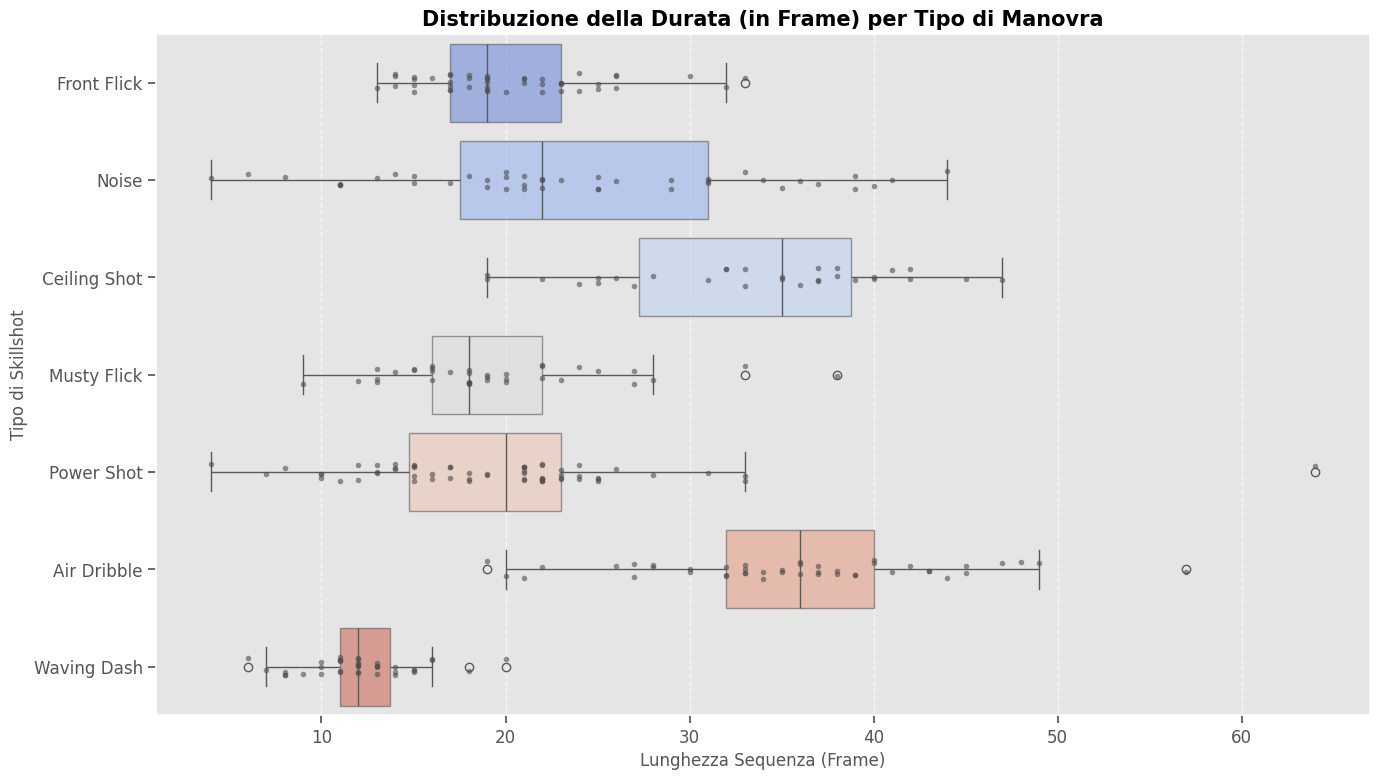

Durata Media Globale: 23.13 frame
Deviazione Standard: 10.38 frame
Conclusione: La durata è altamente variabile sia tra classi diverse che all'interno della stessa classe.
Necessità Metodologica: È obbligatorio trasformare le sequenze in vettori a dimensione fissa (Feature Engineering).


In [3]:
# Mappatura delle etichette numeriche ai nomi delle manovre (da documentazione UCI)
label_map = {
    -1: 'Noise',
    1: 'Ceiling Shot',
    2: 'Power Shot',
    3: 'Waving Dash',
    5: 'Air Dribble',
    6: 'Front Flick',
    7: 'Musty Flick'
}

# 1. Preparazione Dati per l'Analisi
# Raggruppiamo per Sequence_ID per ottenere un'entry per ogni manovra
seq_grouped = df.groupby('Sequence_ID')
seq_stats = pd.DataFrame({
    'Class_Label': seq_grouped['Class_Label'].first(), # La classe è costante nella sequenza
    'Length': seq_grouped.size() # La durata è il numero di righe
})
# Aggiungiamo il nome leggibile
seq_stats['Class_Name'] = seq_stats['Class_Label'].map(label_map)

# --- GRAFICO 1: Distribuzione delle Classi (Donut Chart) ---
plt.figure(figsize=(10, 6))
class_counts = seq_stats['Class_Name'].value_counts()
colors = sns.color_palette('pastel')[0:len(class_counts)]

# Creazione del grafico a ciambella
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140,
        colors=colors, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
plt.title("Distribuzione delle Classi nel Dataset", fontsize=15, fontweight='bold')
# Aggiunta del cerchio bianco centrale per l'effetto Donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

print(f"Osservazione: La classe più frequente è '{class_counts.idxmax()}' ({class_counts.max()} campioni).")
print(f"Osservazione: La classe meno frequente è '{class_counts.idxmin()}' ({class_counts.min()} campioni).")
print("Conclusione: Il dataset è sbilanciato. L'Accuracy non è una metrica affidabile; useremo l'F1-Score Weighted.\n")


# --- GRAFICO 2: Analisi Durata per Classe (Box Plot + Strip Plot) ---
plt.figure(figsize=(14, 8))

# Boxplot per mostrare mediana e quartili
sns.boxplot(x='Length', y='Class_Name', data=seq_stats, palette='coolwarm',
            hue='Class_Name', legend=False, boxprops=dict(alpha=.6))

# Stripplot sovrapposto per mostrare la densità reale dei punti
sns.stripplot(x='Length', y='Class_Name', data=seq_stats, size=4, color=".3", alpha=0.6)

plt.title("Distribuzione della Durata (in Frame) per Tipo di Manovra", fontsize=15, fontweight='bold')
plt.xlabel("Lunghezza Sequenza (Frame)", fontsize=12)
plt.ylabel("Tipo di Skillshot", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistiche sulla durata
avg_len = seq_stats['Length'].mean()
std_len = seq_stats['Length'].std()
print(f"Durata Media Globale: {avg_len:.2f} frame")
print(f"Deviazione Standard: {std_len:.2f} frame")
print("Conclusione: La durata è altamente variabile sia tra classi diverse che all'interno della stessa classe.")
print("Necessità Metodologica: È obbligatorio trasformare le sequenze in vettori a dimensione fissa (Feature Engineering).")

### 4. Feature Engineering: "Advanced Physics & Inputs"

Per trasformare le serie temporali in dati tabulari, adottiamo una strategia progettata specificamente per modelli non lineari (come Random Forest). Ci distanziamo dall'approccio classico (Min/Max/Std) per due motivi:
1.  **Robustezza:** Minimo e Massimo sono sensibili agli outlier del sensore. Usare i **Percentili (25% e 75%)** ci fornisce un range più stabile e rappresentativo della manovra.
2.  **Comportamento del Giocatore:** La semplice media di un tasto (es. "quanto tempo è stato premuto") non distingue tra tenere premuto un tasto o premerlo freneticamente. Introduciamo il **Toggle Count**: il numero di volte che un tasto cambia stato. Questo è cruciale per skillshot come il *Waving Dash*, che richiedono input rapidi e ripetuti.

**Le Feature Generate:**
*   **Variabili Continue (Fisica):** Media, 25° Percentile, 75° Percentile.
*   **Variabili Binarie (Input):** Media (frazione di tempo attivo), Toggle Count (frenesia dell'input).

In [4]:
def perform_advanced_feature_engineering(df):
    """
    Genera feature statistiche robuste e comportamentali (Toggle Count).
    """
    print("Avvio Feature Engineering avanzato...")

    # 1. Separazione delle colonne
    # Identifichiamo le colonne continue e binarie
    input_cols = ['up', 'accelerate', 'slow', 'goal', 'left', 'boost',
                  'camera', 'down', 'right', 'slide', 'jump']

    physics_cols = [c for c in df.columns if c not in input_cols + ['Sequence_ID', 'Class_Label']]

    # 2. Definizione delle funzioni di aggregazione personalizzate
    def q25(x): return x.quantile(0.25)
    def q75(x): return x.quantile(0.75)

    def count_toggles(x):
        """Conta quante volte il segnale cambia valore (es. da 0 a 1 o viceversa)."""
        # x.diff() != 0 individua i cambiamenti. Sottraiamo 1 perché il primo elemento è sempre NaN/diverso.
        return (x.diff().abs() > 0).sum()

    # 3. Aggregazione
    grouped = df.groupby('Sequence_ID')

    # Feature Fisiche: Media e Quartili (Robustezza)
    X_physics = grouped[physics_cols].agg(['mean', q25, q75])

    # Feature Input: Media (Tempo) e Toggle Count (Comportamento)
    X_inputs = grouped[input_cols].agg(['mean', count_toggles])

    # 4. Estrazione Target (y)
    y = grouped['Class_Label'].first()

    # 5. Unione e Pulizia
    X = pd.concat([X_physics, X_inputs], axis=1)

    # Appiattiamo i nomi delle colonne (es. 'BallSpeed_mean')
    X.columns = [f"{col}_{stat}" for col, stat in X.columns]

    # Riempimento eventuali NaN (sicurezza)
    X = X.fillna(0)

    return X, y

# Esecuzione
X, y = perform_advanced_feature_engineering(df)

# Verifica Risultato
print(f"Feature Engineering completato.")
print(f"Dimensioni Matrice X: {X.shape}")
print(f"Dimensioni Target y: {y.shape}")
print("-" * 30)
print("Esempio delle nuove feature generate (prime 5 righe):")
display(X.head())

# Controllo veloce su una feature 'toggle' per vedere se ha senso
print("\nStatistiche della feature 'jump_count_toggles' (quante volte si preme salto):")
print(X['jump_count_toggles'].describe())

Avvio Feature Engineering avanzato...
Feature Engineering completato.
Dimensioni Matrice X: (298, 43)
Dimensioni Target y: (298,)
------------------------------
Esempio delle nuove feature generate (prime 5 righe):


,BallAcceleration_mean,BallAcceleration_q25,BallAcceleration_q75,Time_mean,Time_q25,Time_q75,DistanceWall_mean,DistanceWall_q25,DistanceWall_q75,DistanceCeil_mean,...,camera_mean,camera_count_toggles,down_mean,down_count_toggles,right_mean,right_count_toggles,slide_mean,slide_count_toggles,jump_mean,jump_count_toggles
Sequence_ID,,,,,,,,,,,,,,,,,,,,,
1,-3853.867885,-582.114983,2349.548745,2.326591,1.171937,3.359623,3770.785313,3569.5875,3900.4225,1985.264375,...,0.062500,4,0.0,0,0.812500,6,0.218750,8,0.281250,11
2,-848.813985,-5907.598280,1625.944848,3.261104,1.406705,5.209483,1698.631795,224.9200,3029.4850,1162.348462,...,0.102564,4,0.0,0,1.000000,0,0.461538,13,0.256410,7
3,-1264.766385,-2739.747949,774.922967,3.453076,1.111459,6.434242,1796.122941,179.3350,3580.2575,1158.123529,...,0.088235,5,0.0,0,1.000000,0,0.117647,8,0.205882,5
4,-2133.341430,-3963.022851,1743.723579,1.612082,1.093555,2.256627,1072.541739,369.2650,1571.8750,478.427826,...,0.130435,4,0.0,0,1.000000,0,0.347826,9,0.478261,3
5,-7148.505767,-1034.700028,2498.080374,1.311509,0.477387,1.796730,3800.485000,3754.5900,3876.0600,1996.488636,...,0.136364,4,0.0,0,0.727273,2,0.318182,5,0.227273,5



Statistiche della feature 'jump_count_toggles' (quante volte si preme salto):
count    298.000000
mean       4.359060
std        3.172154
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       16.000000
Name: jump_count_toggles, dtype: float64


### 5. Preprocessing: Encoding e Divisione Stratificata

Prima della modellazione, eseguiamo due operazioni fondamentali:

1.  **Label Encoding:** Le etichette originali del dataset sono disordinate (-1, 1, 2, 5...). Le mappiamo in un range sequenziale (0-6) per una gestione più pulita nelle matrici di confusione.
2.  **Divisione Train/Test (80/20):** A differenza di approcci che riservano il 30% al test, optiamo per un **Test Set del 20%**. Dato il numero limitato di campioni (298), massimizzare la quantità di dati disponibili per il training (80%) è cruciale per permettere a modelli complessi come il Random Forest di apprendere pattern stabili senza andare in overfitting.

La divisione è rigorosamente **stratificata** per mantenere le proporzioni delle classi identiche tra i due set.

Mapping delle Classi: {0: 'Noise', 1: 'Ceiling Shot', 2: 'Power Shot', 3: 'Waving Dash', 4: 'Air Dribble', 5: 'Front Flick', 6: 'Musty Flick'}
----------------------------------------
Training Set: 238 campioni
Test Set:     60 campioni
----------------------------------------


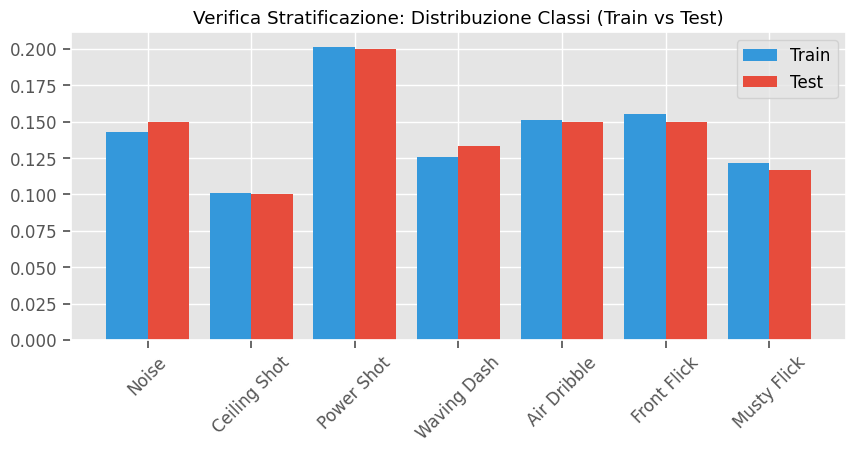

Check: Le barre blu e rosse dovrebbero avere altezze quasi identiche per ogni classe.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Label Encoding (Pulizia delle etichette target)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Mappatura inversa per decodificare in futuro (es. 0 -> 'Noise')
# Creiamo un dizionario utile per i grafici futuri
target_names = [label_map[label] for label in le.classes_]
print(f"Mapping delle Classi: {dict(zip(range(len(target_names)), target_names))}")

# 2. Divisione Stratificata 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.20,      # 20% Test (invece del 30% del riferimento)
    stratify=y_encoded,  # Mantiene le proporzioni
    random_state=42
)

# 3. Verifica della Distribuzione
print("-" * 40)
print(f"Training Set: {X_train.shape[0]} campioni")
print(f"Test Set:     {X_test.shape[0]} campioni")
print("-" * 40)

# Visualizzazione rapida per confermare la stratificazione
plt.figure(figsize=(10, 4))
plt.hist([y_train, y_test], label=['Train', 'Test'], density=True, color=['#3498db', '#e74c3c'], bins=np.arange(8)-0.5)
plt.xticks(ticks=range(7), labels=target_names, rotation=45)
plt.legend()
plt.title("Verifica Stratificazione: Distribuzione Classi (Train vs Test)")
plt.show()

print("Check: Le barre blu e rosse dovrebbero avere altezze quasi identiche per ogni classe.")

### 6. Selezione del Modello: Random Forest vs SVM

Per la fase di classificazione, ci discostiamo dai modelli lineari (come Logistic Regression) utilizzati in approcci standard, optando per algoritmi capaci di catturare relazioni non lineari complesse tra le feature comportamentali e fisiche.

Mettiamo a confronto due architetture tramite **Stratified 5-Fold Cross-Validation**:

1.  **Random Forest (Ensemble):** Un modello basato su una foresta di alberi decisionali.
    *   *Perché:* Gestisce eccellentemente feature miste (continue e discrete come i "Toggle Counts") ed è intrinsecamente robusto agli outlier. Non richiede necessariamente la normalizzazione dei dati.
2.  **Support Vector Machine (Kernel RBF):**
    *   *Perché:* Efficace in spazi ad alta dimensionalità e su dataset di dimensioni contenute. Richiede obbligatoriamente lo scaling delle feature (StandardScaler) per funzionare correttamente.

Valutiamo i modelli utilizzando l'**F1-Score Weighted**, la metrica più onesta per classi sbilanciate.

Avvio della Cross-Validation (5-Fold)...
------------------------------------------------------------
Modello              | F1-Score Medio  | Std Dev   
------------------------------------------------------------
Random Forest        | 0.8764             | +/- 0.0433
SVM (RBF Kernel)     | 0.7816             | +/- 0.0462
------------------------------------------------------------


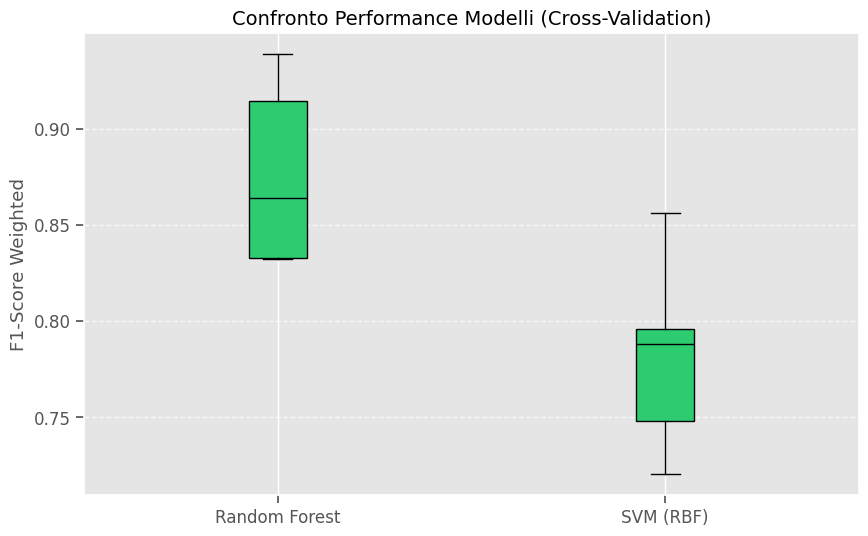

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

# 1. Configurazione della Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Definizione delle Pipeline
pipelines = {
    'Random Forest': Pipeline([
        # Nessun scaler necessario per RF
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'SVM (RBF Kernel)': Pipeline([
        ('scaler', StandardScaler()), # SVM richiede dati scalati
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# 3. Esecuzione del Torneo
results = {}
print("Avvio della Cross-Validation (5-Fold)...")
print("-" * 60)
print(f"{'Modello':<20} | {'F1-Score Medio':<15} | {'Std Dev':<10}")
print("-" * 60)

# Nota: Assumiamo che X_train e y_train siano già definiti nel tuo notebook
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_weighted')

    # Salviamo i risultati
    results[name] = scores

    # Output formattato
    print(f"{name:<20} | {scores.mean():.4f}             | +/- {scores.std():.4f}")

print("-" * 60)

# 4. Visualizzazione Grafica dei Risultati
plt.figure(figsize=(10, 6))

# --- MODIFICA APPLICATA QUI SOTTO ---
# 'labels' è stato cambiato in 'tick_labels' per risolvere il warning
plt.boxplot([results['Random Forest'], results['SVM (RBF Kernel)']],
            tick_labels=['Random Forest', 'SVM (RBF)'],
            patch_artist=True,
            boxprops=dict(facecolor='#2ecc71', color='black'),
            medianprops=dict(color='black'))

plt.title("Confronto Performance Modelli (Cross-Validation)", fontsize=14)
plt.ylabel("F1-Score Weighted")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### 7. Ottimizzazione del Modello (Hyperparameter Tuning)

Dato che il **Random Forest** è risultato il modello superiore, procediamo all'ottimizzazione dei suoi iperparametri per massimizzare la generalizzazione e prevenire l'overfitting.

A differenza di un tuning manuale su singolo parametro, utilizziamo una **GridSearchCV** (Ricerca a Griglia) per testare simultaneamente diverse combinazioni di:
*   `n_estimators`: Il numero di alberi nella foresta (stabilità).
*   `max_depth`: La profondità massima di ogni albero (controllo complessità).
*   `min_samples_split`: Il numero minimo di campioni per dividere un nodo (robustezza).

La metrica di selezione rimane l'**F1-Score Weighted**.

In [7]:
from sklearn.model_selection import GridSearchCV

# 1. Definizione della Griglia di Iperparametri
# I parametri devono avere il prefisso 'clf__' perché sono dentro una Pipeline
param_grid = {
    'clf__n_estimators': [50, 100, 200],      # Numero di alberi
    'clf__max_depth': [None, 10, 20],         # Profondità massima (None = espansione completa)
    'clf__min_samples_split': [2, 5, 10],     # Minimo campioni per split
    'clf__criterion': ['gini', 'entropy']     # Criterio di impurità
}

# 2. Configurazione della Grid Search
# Usiamo la pipeline del Random Forest definita al passo precedente
grid_search = GridSearchCV(
    estimator=pipelines['Random Forest'],
    param_grid=param_grid,
    cv=5,                       # Sempre 5-Fold Cross Validation
    scoring='f1_weighted',      # Ottimizziamo per F1-Score
    n_jobs=-1,                  # Usa tutti i core della CPU in parallelo
    verbose=1
)

# 3. Esecuzione
print("Inizio Tuning del Random Forest...")
grid_search.fit(X_train, y_train)

# 4. Risultati
print("-" * 60)
print(f"Miglior F1-Score (CV): {grid_search.best_score_:.4f}")
print("Migliori Iperparametri trovati:")
print(grid_search.best_params_)
print("-" * 60)

# Salviamo il modello migliore per la fase finale
best_model = grid_search.best_estimator_

Inizio Tuning del Random Forest...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
------------------------------------------------------------
Miglior F1-Score (CV): 0.8764
Migliori Iperparametri trovati:
{'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
------------------------------------------------------------


### 8. Valutazione Finale sul Test Set e Interpretabilità

Validiamo le prestazioni del modello ottimizzato sul **Test Set** (dati mai visti durante il training).

Oltre alle metriche standard (Classification Report e Matrice di Confusione), sfruttiamo la natura del **Random Forest** per analizzare la **Feature Importance**. A differenza dei modelli basati su PCA (che oscurano il significato delle variabili originali), qui possiamo identificare esattamente quali caratteristiche cinematiche o di input (es. "frenesia" sui tasti vs velocità della palla) sono determinanti per classificare uno skillshot.

--- REPORT FINALE SUL TEST SET ---
Accuracy Modello: 0.8667
Accuracy Baseline: 0.1333
------------------------------------------------------------
              precision    recall  f1-score   support

       Noise       1.00      0.56      0.71         9
Ceiling Shot       0.75      1.00      0.86         6
  Power Shot       1.00      1.00      1.00        12
 Waving Dash       1.00      1.00      1.00         8
 Air Dribble       1.00      0.89      0.94         9
 Front Flick       0.75      1.00      0.86         9
 Musty Flick       0.57      0.57      0.57         7

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.85        60
weighted avg       0.89      0.87      0.86        60



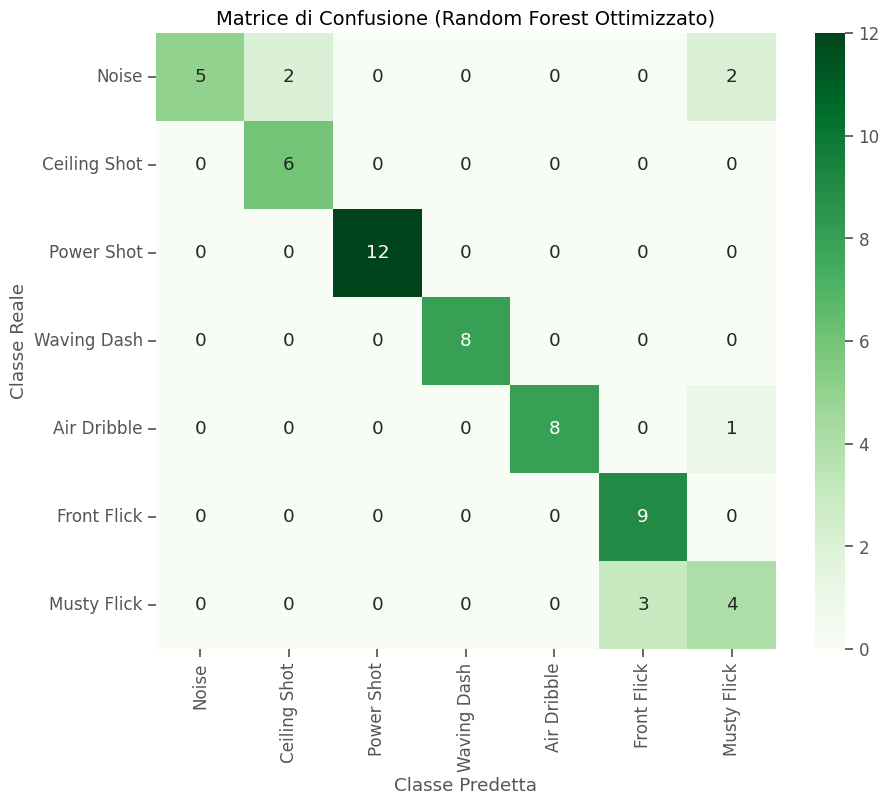

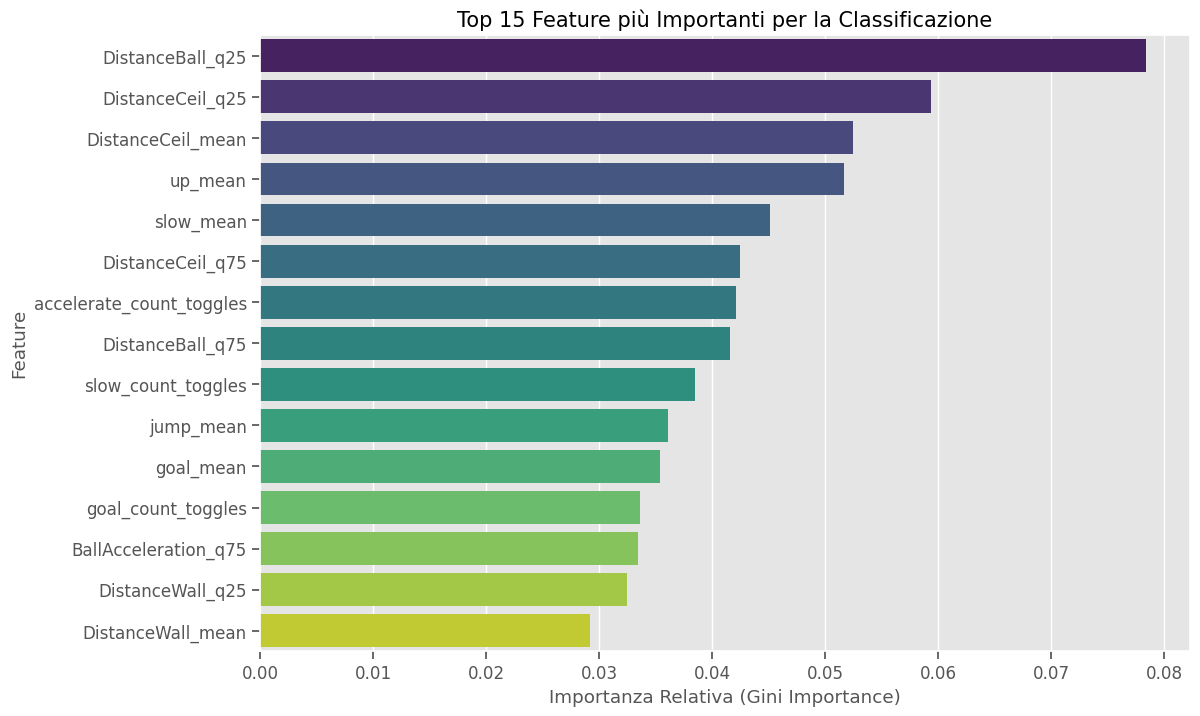

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Predizioni sul Test Set
y_pred = best_model.predict(X_test)

# 2. Baseline (per confronto)
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

# 3. Metriche Finali
print("--- REPORT FINALE SUL TEST SET ---")
print(f"Accuracy Modello: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy Baseline: {accuracy_score(y_test, y_dummy):.4f}")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=target_names))

# 4. Visualizzazione Matrice di Confusione
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Usiamo il verde (Forest) invece del blu standard
            xticklabels=target_names, yticklabels=target_names)
plt.title("Matrice di Confusione (Random Forest Ottimizzato)", fontsize=14)
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Reale")
plt.show()

# 5. Feature Importance (Il vantaggio del Random Forest)
# Estraiamo l'importanza dal modello dentro la pipeline
rf_model = best_model.named_steps['clf']
importances = rf_model.feature_importances_
feature_names = X.columns

# Creiamo un DataFrame per ordinare le feature
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15) # Top 15

# Plot delle feature più importanti
plt.figure(figsize=(12, 8))

# --- MODIFICA APPLICATA QUI SOTTO ---
# Assegniamo 'Feature' a 'hue' e nascondiamo la legenda per soddisfare le nuove regole di Seaborn
sns.barplot(x='Importance', y='Feature', data=feature_imp_df,
            hue='Feature', palette='viridis', legend=False)

plt.title("Top 15 Feature più Importanti per la Classificazione", fontsize=15)
plt.xlabel("Importanza Relativa (Gini Importance)")
plt.ylabel("Feature")
plt.show()

### 9. Conclusioni e Analisi dei Risultati

Il progetto ha raggiunto l'obiettivo di classificare skillshot complessi di Rocket League con un'accuratezza finale del **86.67%** sul Test Set, superando significativamente la baseline casuale (13.33%).

L'analisi del modello **Random Forest** ci ha permesso di validare le nostre ipotesi di Feature Engineering:
1.  **Vittoria della Robustezza:** Le feature basate sui **Quartili** (es. `DistanceBall_q25`) si sono rivelate le più predittive in assoluto, confermando che statistiche robuste sono superiori a semplici minimi/massimi in presenza di dati rumorosi.
2.  **Importanza del Comportamento:** L'introduzione della metrica **Toggle Count** (es. `accelerate_count_toggles`) è stata determinante, posizionandosi tra le top feature. Questo dimostra che la frequenza di input ("spamming" vs pressione costante) è un tratto distintivo fondamentale delle manovre avanzate.

In conclusione, l'uso di un modello non lineare combinato con un feature engineering "fisico-comportamentale" ha permesso di ottenere un classificatore robusto e interpretabile.